![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# XAI in deep learning-based image analysis: Explain CNNs

---

In this third tutorial, we are going to compare different explainability methods for image classification performed with CNNs. We will:
- Apply Grad-CAM on a new image
- Use the SHAP library to get the SHAP values on the same image
- Compare the two methods
- Discuss the limitation of XAI for CNNs

TO DO: add Colab

In [64]:
# Installing the necessary packages

%matplotlib inline 
from tools.gradcam_model import GradCamModel
import torch, torchvision
from torch import nn
from torchvision import transforms, models, datasets
from torchvision.models import resnet50,ResNet50_Weights
import shap
import json
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Image explanation

As mentioned in the introduction, there are two main kinds of explainability methods for images:

- occlusion- or perturbation-based methods
- gradient-based methods

The first ones consist of manipulating/masking parts of the image to generate explanations. Some examples of these are LIME and SHAP.
The second one consists of leveraging the gradient of the function so that a mapping of the function value onto multiple input dimensions is readily obtained. There are many gradient-based methods (e.g. Grad-CAM, Integrated Gradients, SmoothGradthat differ in how these gradients are computed.

In this tutorial, we will compare the results from Grad-CAM with the SHAP library that we already used in the first part of the course.
In particular, this library combines together occlusion- and gradient-based methods, providing a visual explanation that is very similar to the SHAP values you are already familiar with.

### GradCAM results

Let's start opening the results of the Grad-CAM implementation on our iguana image.

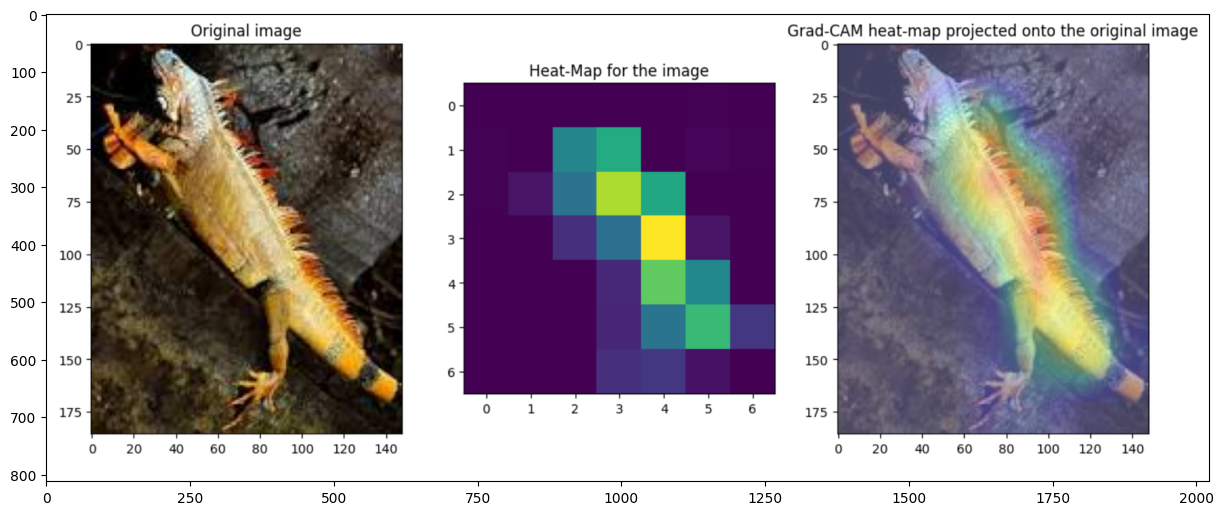

In [77]:
# read and visualize the image

def read_img(path_to_img):
    img = cv.imread(path_to_img) # Insert the path to image.
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img
    
path_to_img = '../../docs/source/_figures/iguana_GradCAM.png'
img = read_img(path_to_img)
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()

## SHAP for image classification

### How does SHAP work?
To summarize what we learnt in the first part of the course:

* SHAP is based on the computation of the **Shapley values**, a method to calculate the contributions of each player to the outcome of a game.
* The Shapley values are calculated with all possible combinations of players. Given N players, it has to calculate outcomes for 2^N combinations of players. In the case of machine learning, the “players” are the features (e.g. pixels in an image), and the “outcome of a game” is the model’s prediction. Calculating the contribution of each feature is not feasible for large numbers of N. For example, for images, N is the number of pixels.
* Therefore, SHAP does not attempt to calculate the actual Shapley value. Instead, it uses sampling and approximations to calculate the SHAP value.
  
In the SHAP library, there are multiple explainers that can be used to explain which features are important in an image for classification. Some of them are:
* [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html)
* [PartitionExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.PartitionExplainer.html)
* [GradientExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.GradientExplainer.html#shap.GradientExplainer)

All of the above uses specific methods to approximate SHAP values for deep learning models.
In this course, we will focus on the implementation of GradientExplainer, but you can read more about each explainer in the [SHAP documentation](https://shap-lrjball.readthedocs.io/en/latest/api.html#core-explainers).

### How to visualize SHAP attributions?
SHAP uses colors to explain attribution:
- Red pixels increase the probability of a class being predicted
- Blue pixels decrease the probability of a class being predicted

The image below (credit: [SHAP documentation](https://github.com/shap/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models)), is the output of the DeepExplainer for four digits on the MNIST dataset. The input images are shown on the left column and the other columns show the SHAP value for the classes from 1 to 9, with the original image nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output. Note that for the 'zero' image the blank middle is important, while for the 'four' image the lack of a connection on top makes it a four instead of a nine.

![](https://raw.githubusercontent.com/shap/shap/master/docs/artwork/mnist_image_plot.png)

### SHAP on a custom image

Let's start loading the iguana image and the ImageNet classes.

In [51]:
# read and visualize the image
path_to_img = 'images/Iguana.jpeg'
img = read_img(path_to_img)


# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

Before passing the image to SHAP, we need to transfomr it using the ImageNet transformation (transform to tensor, resize, normalize). In the next cell we define the functions necessary for the image transformations.

In [52]:
# define the transformations (here we are using the ImageNet transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def transform_img(img, tensor_flag=True ):
    transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
    arr_img = np.array(img)
    # apply the transforms
    trans_img = transform(arr_img)
    # unsqueeze to add a batch dimension
    trans_img = trans_img.unsqueeze(0)
    if tensor_flag is False:
        # returns np.array with original axes
        trans_img = np.array(trans_img)
        trans_img = trans_img.swapaxes(-1,1).swapaxes(1, 2)

    return trans_img

def normalize_and_adjust_axes(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axes so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

We define the CNNs model that we will use for the classifcation with the same ResNet50 architecture we already used in the previous tutorials.

In [53]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).eval()

We can now focus on SHAP implementation.
#### Step 1 - Create a baseline
We select part of the ImageNet data set to create a baseline, i.e. the background dataset to use for integrating our features.

In [54]:
X, y = shap.datasets.imagenet50()

#### Step 2 - Instantiate the class
We decided to focus on GradientExplainer which ...
The first argument is tuple containing the model and the layer (if the input is a tuple, the returned shap values will be for the input of the layer argument). The second argument is the background dataset.

In [55]:
e = shap.GradientExplainer((model, model.layer4), normalize_and_adjust_axes(X))

#### Step 3 - Compute SHAP values on the custom image
In the shap_value method we pass the image we want to expalin as a tensor, and setting ranked_outputs=2 we only explain the top 2 model outputs.

In [59]:
img_to_explain = transform_img(img)
shap_values, indexes = e.shap_values(img_to_explain, ranked_outputs=4)

#### Step 4 - Plot results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


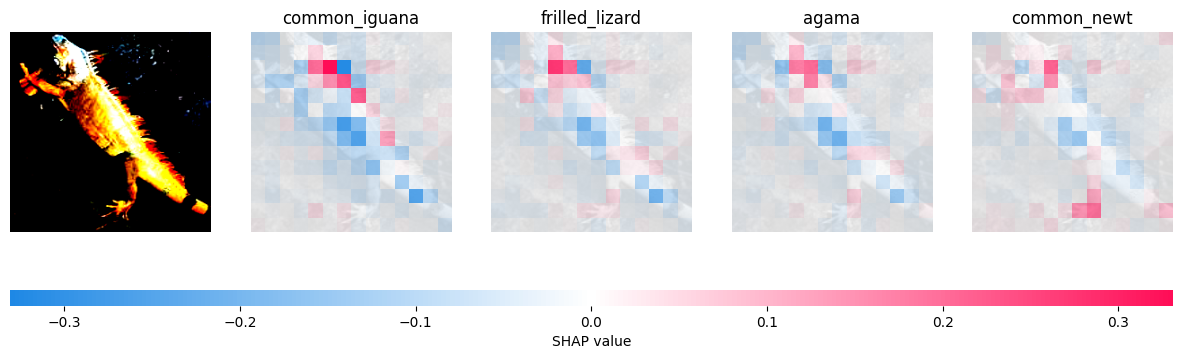

In [60]:
# Rotate SHAP values to the original orientation (if necessary)
shap_values_rotated = [np.rot90(s, k=3) for s in shap_values] #??? Ask Harsha, to keep?

# Get classes names
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# Transform image for plotting
img_explained_to_plot = transform_img(img, False)

# Plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values] # unroll the axes
shap.image_plot(shap_values, img_explained_to_plot, index_names)

As mentioned before, the red pixels contribute positively to the respective class, while the blue pixels contribute negatively. Grey pixels have a near-zero SHAP value. We can see that the rows of spines running down the back is contributing to the prediction of the iguana class, and not to the frilled lizard one.

## Pros and Cons of SHAP
Pro:
- Strong theoretical foundation

Con:
- Computation complexity and time
- The choice of baseline images can significantly affect SHAP results (or any method which relies on baselines) - https://distill.pub/2020/attribution-baselines/

## Limitations of XAI for images

- The relevance and resistance of saliency maps should be taken into consideration in future works to validate the trustworthiness of medical AI explainability ([Zhang et al., 2022](https://link.springer.com/chapter/10.1007/978-3-031-16437-8_43)).

![Title](../../docs/source/_figures/relevance_resistance.png)

- Stop Explaining Black Box Models for High Stakes Decisions and Use Interpretable Models Instead
    
    Saliency maps are often considered to be explanatory. Saliency maps can be useful to determine what part of
    the image is being omitted by the classifier, but this leaves out all information about how relevant information
    is being used. Knowing where the network is looking within the image does not tell the user what it is doing
    with that part of the image, as illustrated in Figure 2. In fact, the saliency maps for multiple classes could be
    essentially the same; in that case, the explanation for why the image might contain a Siberian husky would be
    the same as the explanation for why the image might contain a transverse flute.
  
![Title](../../docs/source/_figures/Husky.png)

- The Disagreement Problem in Explainable Machine Learning: A Practitioner’s Perspective
![Title](../../docs/source/_figures/comparison.png)

## Adversarial attacks